# Gaussian Mixture Model via Gradient Descent

#### Lab from [Caio Corro](https://caio-corro.fr/)

In this exercise, we will see how we can train a Gaussian Mixture Model (GMM) via gradient descent:

- first, we will consider independant bivariate Gaussians, i.e. the correlation coefficients in the correlation matrix are null, therefore we can simply store the diagonal and model each coordinate independently - this part is already done, you just need to study the code to understand it
- second, we will consider bivariate Gaussian with (possibly) non null correlation coefficients

Your goal is to study this code, play with params and understand what is going on!

In [2]:
# import a lot of useful stuff

import numpy as np
import math
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
import scipy.stats
from sklearn.datasets import make_circles

import torch
import torch.nn as nn
import torch.optim
import math
%matplotlib inline

## 1. Simple preliminary example

In this section, we illustrate how we use Pytorch for optimizing the parameters of a probability distribution.

In [3]:
# A Pytorch module is an object that contains parameters that we are going to learn,
# in this case the parameters of an univariate Gaussian.
# It also defines a forward pass function.
class UnivariateGaussian(nn.Module):
    def __init__(self):
        super().__init__()
        
        # an univariate Gaussian is defined by a mean and a standard deviation
        self.mean = nn.Parameter(torch.zeros(1))
        # the standard deviation (std) of a Gaussian must be strictily positive.
        # Instead, we will learn the log of the std which is unconstrained.
        # then, log_std.exp() is equal to the std
        self.log_std = nn.Parameter(torch.zeros(1))
        
    # the forward function return the log of the PDF
    def forward(self, x):
        return \
            - math.log(math.sqrt(2 * math.pi)) \
            - self.log_std \
            - 0.5 * ((x - self.mean) ** 2) / (self.log_std.exp() ** 2)

In [4]:
# We generate training data from a Gaussian with mean 5 and std 2
gold_data = torch.FloatTensor([np.random.normal(loc=5, scale=2) for _ in range(1000)])

# we can estimate the mean and std from the data using the closed form formula
print("Closed form solution:")
print(" - mean =", gold_data.mean())
print(" - std =", gold_data.std(unbiased=False))

Closed form solution:
 - mean = tensor(5.0045)
 - std = tensor(1.9914)


In [5]:
# create an univariate Gaussian
unig = UnivariateGaussian()

# optimizer
optimizer = torch.optim.SGD(unig.parameters(), lr=0.01, momentum=0.9)
# We could have also used Adam
#optimizer = torch.optim.Adam(unig.parameters(), lr=0.1)

# Training loop,
# We do 1000 gradient updates here
for _ in range(1000):
    # we first need to set the gradient to 0
    # the reason is that each call to the .backward function *accumulate* gradient
    optimizer.zero_grad()
    
    # compute the log PDF each each data sample,
    # log_pdf is a vector of the size of the dataset
    log_pdf = unig(gold_data)
    
    # we sum all PDF and then normalize
    # it is usual to normalize by the number of sample
    # so that the objective don't explode.
    # i.e. the parameter estimation problem is:
    # min_theta -\sum_x (1/|D|) * log p(x)
    loss = -torch.sum(log_pdf) / len(gold_data)

    loss.backward() # compute the gradient
    optimizer.step() # update the parameters
    
print("Learned model:")
print(" - mean =", unig.mean.item())
print(" - std =", unig.log_std.exp().item())

Learned model:
 - mean = 5.004534721374512
 - std = 1.991439700126648


In the following we solve the same problem but using stochastic gradient descent, i.e. at each update we use only a batch of data.

In [6]:
unig = UnivariateGaussian()
optimizer = torch.optim.SGD(unig.parameters(), lr=0.01, momentum=0.9)

# Here, 100 is not the number of updates
# but the number of time we will loop over the data
for _ in range(100):
    # we permute the dataset so at each
    # iteration we will look at the data
    # in a different order
    gold_data[:] = gold_data[torch.randperm(len(gold_data))]
    
    # batch of size 10
    for i in range(0, len(gold_data), 10):
        batch = gold_data[i : i+10]
        optimizer.zero_grad()

        log_pdf = unig(batch)
        # here we norm by the size of the batch
        loss = -torch.sum(log_pdf) / len(batch)

        loss.backward() # compute the gradient
        optimizer.step() # update the parameters
    
print("Learned model:")
print(" - mean =", unig.mean.item())
print(" - std =", unig.log_std.exp().item())

Learned model:
 - mean = 5.0400285720825195
 - std = 2.145343780517578


## 2. Data

We now generate the data we will use. They come from 3 different bivariate Gaussians where only one of them has a non null correlation.

In [7]:
n_coordinates = 2

n_gold_clusters = 3
n_gold_samples = 1000

# The prior distribution on clusters is not uniform!
gold_cluster_prior = [0.2, 0.4, 0.4]

gold_x_means = np.array(np.array([ [-1, -1], [-1, 1], [1, 1] ]))
gold_x_cov = np.array([
    [
        [0.5**2, 0],
        [0, 0.2**2],
    ],
    [
        [0.3**2, 0],
        [0, 0.3**2],
    ],
    [
        [0.4**2, 0.8 * 0.4 * 0.5],
        [0.8 * 0.4 * 0.5, 0.5**2],
    ],
])

# sampling

# first we sample the cluster for each point
gold_clusters = np.random.choice(n_gold_clusters, n_gold_samples, p=gold_cluster_prior)

# then we sample the coordinates
gold_data = np.empty((n_gold_samples, n_coordinates))
for i in range(n_gold_samples):
    gold_data[i] = np.random.multivariate_normal(gold_x_means[gold_clusters[i]], gold_x_cov[gold_clusters[i]])

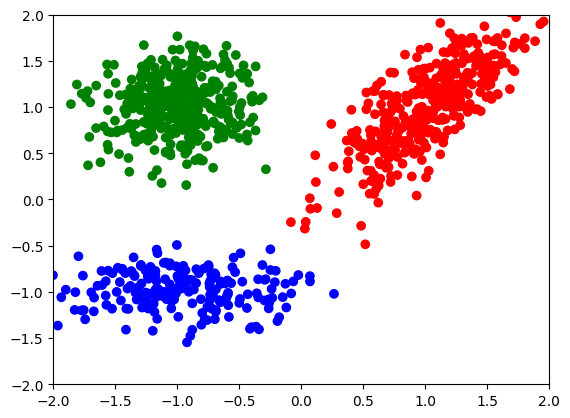

In [8]:
colors = np.array(["blue", "green", "red"])

fig, ax = plt.subplots()
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

ax.scatter(gold_data[:,0], gold_data[:,1], color=colors[gold_clusters])

## GMM with diagonal covariance matrices

**IMPORTANT** You need to exactly understand what is going on in the forward function!

In [9]:
class GaussianMixture(nn.Module):
    def __init__(self, n_clusters, n_coordinates):
        super().__init__()
        
        # Parameters of the prior distribution
        # we will simply take the softmax of this to get cluster distribution
        # so no constraint on this :)
        self.prior = nn.Parameter(torch.zeros(n_clusters))
        
        self.mean = nn.Parameter(torch.empty((1, n_clusters, n_coordinates)).normal_())
        # as the covariance matrix is assumed to be diagonal,
        # we represent them by vector of unconstrained log standard deviation
        self.log_std = nn.Parameter(torch.empty((1, n_clusters, n_coordinates)).normal_())
        
    # return log of the pdf (i.e. marginalize over the latent variable)
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(1)
        # shape: (n_sample, n_latent, n_output)
        pdf = \
            - math.log(math.sqrt(2 * math.pi)) \
            - self.log_std \
            - 0.5 * ((x - self.mean) ** 2) / (self.log_std.exp() ** 2)
        
        # reduce last dim
        pdf = pdf.sum(dim=2)
        pdf = pdf + self.prior.log_softmax(0).unsqueeze(0)
        pdf = pdf.logsumexp(dim=1)
        
        # shape of the return tensor is (n_sample,)
        return pdf

In [10]:
# just a function to visualize the result!
# not that there are only seven colors, so you can go only up to 7 clusters...
def visualize_independent_mixture(g):
    # sample from the learned distribution
    pred_prior = np.random.choice(g.prior.shape[0], 1000, p=g.prior.softmax(0).detach().numpy())
    pred = np.random.normal(
        loc=g.mean[0, pred_prior].detach().numpy(),
        scale=g.log_std[0, pred_prior].exp().detach().numpy()
    )

    colors = np.array([c for c in "bgrcmyk"])
    # you can do this if you want to visualize with more clusters,
    # but several clusters will have the same color...
    #colors = np.array([c for c in "bgrcmykbgrcmykbgrcmykbgrcmyk"])

    fig, ax = plt.subplots()

    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))

    ax.scatter(pred[:,0], pred[:,1], color=colors[pred_prior])

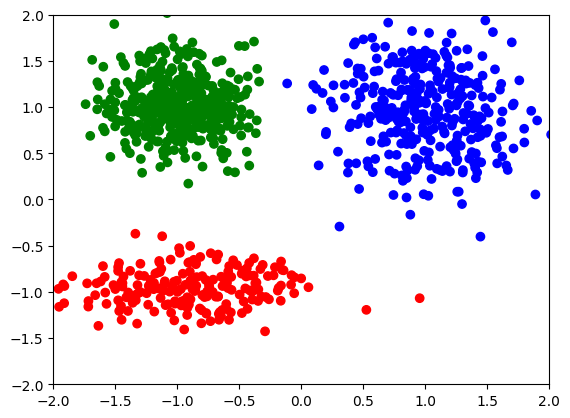

In [11]:
# Train the model with 3 latent clusters
# Note that sometimes it can completely fail (because the objective is non-convex!)
# just rerun it! :)
n_clusters = 3
g = GaussianMixture(n_clusters, n_coordinates)

optimizer = torch.optim.SGD(g.parameters(), lr=0.1, momentum=0.9)

for _ in range(1000):
    optimizer.zero_grad()
    loss = -torch.sum(g(torch.from_numpy(gold_data))) / len(gold_data)
    loss.backward()
    optimizer.step()
    
visualize_independent_mixture(g)

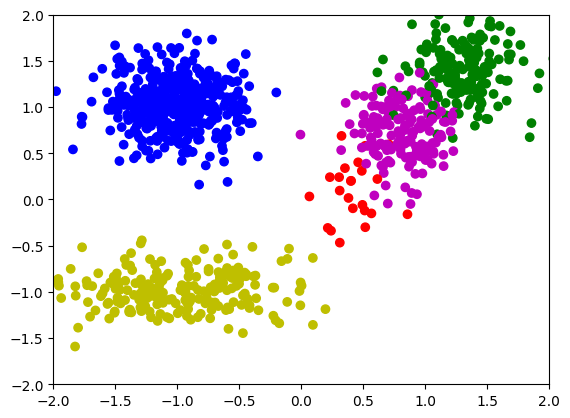

In [12]:
# On of the cluster in the dataset has a full covariance matrix,
# we cannot approximate it with a single Gaussian that has independent coordinate,
# but we can increase the number of cluster in our model to try to fit it with 
# several bivariate Gaussians!
n_clusters = 6
g = GaussianMixture(n_clusters, n_coordinates)

optimizer = torch.optim.SGD(g.parameters(), lr=0.1, momentum=0.9)

for _ in range(1000):
    optimizer.zero_grad()
    loss = -torch.sum(g(torch.from_numpy(gold_data))) / len(gold_data)
    loss.backward()
    optimizer.step()
    
visualize_independent_mixture(g)

## GMM with full covariance matrices

We will now move to the same example, but using a model that can learn models with non null correlation between coordinates.

The trick we use here is to represent the parameterization as explained here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case

The correlation coefficient must be in [-1, 1]. Instead, we learn unconstrained parameters and reparameterize them via the hyperbolic tangent function.

In [13]:
class GaussianMixture(nn.Module):
    # we only pass the number of clusters,
    # we have a single correlation coefficient
    # so we are restricted to 2 coordinates only
    def __init__(self, n_clusters):
        super().__init__()
        
        # Parameters of the prior distribution
        # we will use an exponential parameterization of the categorical distribution
        # so no constraint on this :)
        self.prior = nn.Parameter(torch.zeros(n_clusters))

        
        self.mean = nn.Parameter(torch.empty((1, n_clusters, 2)).normal_())
        self.log_std = nn.Parameter(torch.empty((1, n_clusters, 2)).normal_())
        
        # The correlation coefficient
        # not that we learn a reparameterization that is unconstrained,
        # and the coef is self.reparemeterized_coef.tanh(),
        # so the value is between -1 and 1 as expected
        # (one limitation is that we can't have a coef=1 or =-1, but who cares?)
        self.reparameterized_coef = nn.Parameter(torch.empty((1, n_clusters)).normal_())
        
    # return log of the pdf (i.e. marginalize over the latent variable)
    # formula is avalable here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case
    # remember we are interested by the log PDF!
    def forward(self, x):
        # shape x: (n_sample, 1, n_output)
        x = x.unsqueeze(1)
        p = self.reparameterized_coef.tanh()
        # shape: (n_sample, n_latent, n_output)

        pdf = \
            - torch.log(2 * math.pi * self.log_std.exp().prod(2) * torch.sqrt(1 - p*p)) \
            - (1 / (2 * (1 - p * p))) * (
                ((x - self.mean).pow(2) / (self.log_std.exp().pow(2))).sum(2)
                - 2 * p * (x - self.mean).prod(2) / self.log_std.exp().prod(2)
            )
        
        pdf = pdf + self.prior.log_softmax(0).unsqueeze(0)
        pdf = pdf.logsumexp(dim=1)
        
        # shape of the return tensor is (n_sample,)
        return pdf

In [14]:
# On of the cluster in the dataset has a full covariance matrix,
# we cannot approximate it with a single Gaussian that has independent coordinate,
# but we can increase the number of cluster in our model to try to fit it with 
# several bivariate Gaussians!
n_clusters = 3
g = GaussianMixture(n_clusters)

optimizer = torch.optim.SGD(g.parameters(), lr=0.01, momentum=0.9)

for _ in range(1000):
    optimizer.zero_grad()
    loss = -torch.sum(g(torch.from_numpy(gold_data))) / len(gold_data)
    loss.backward()
    optimizer.step()

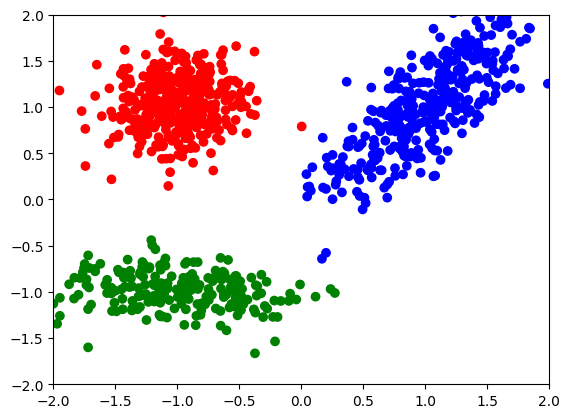

In [15]:
# sample from the learned distribution
pred_prior = np.random.choice(g.prior.shape[0], 1000, p=g.prior.softmax(0).detach().numpy())

x_means = g.mean.squeeze(0).detach().numpy()
x_cov = np.empty((g.prior.shape[0], 2, 2))
for i in range(g.prior.shape[0]):
    std1 = g.log_std[0, i, 0].exp().item()
    std2 = g.log_std[0, i, 1].exp().item()
    p = g.reparameterized_coef[0, i].tanh().item()

    x_cov[i, 0, 0] = std1 * std1
    x_cov[i, 1, 1] = std2 * std2
    x_cov[i, 0, 1] = std1 * std2 * p
    x_cov[i, 1, 0] = std1 * std2 * p

# then we sample the coordinates
pred = np.empty((1000, 2))
for i in range(1000):
    pred[i] = np.random.multivariate_normal(x_means[pred_prior[i]], x_cov[pred_prior[i]])

colors = np.array([c for c in "bgrcmyk"])
# you can do this if you want to visualize with more clusters,
# but several clusters will have the same color...
#colors = np.array([c for c in "bgrcmykbgrcmykbgrcmykbgrcmyk"])

fig, ax = plt.subplots()

ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

ax.scatter(pred[:,0], pred[:,1], color=colors[pred_prior])